In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from glob import glob
import joblib

In [3]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        
        self.Linear1 = nn.Linear(256*14*14, 64)
        self.Linear2 = nn.Linear(64, 2)
                
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)

        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)

In [4]:
model = MultiClassifier()

In [5]:
model.load_state_dict(torch.load('./celeba_cls.pth'))

<All keys matched successfully>

In [6]:
model = model.cuda()

In [7]:
# base = 'exp/image_samples/1020_MNIST_EXP_EXP2_K2_IMAGE_SIZE_28_BATCH_128_TWCII/'
# base = 'exp/image_samples/1020_MNIST_EXP_EXP10_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'
# base = 'exp/image_samples/1023_MNIST_EXP_EXPINF_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/1023_FashionMNIST_EXP_EXPINF_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/1109_FashionMNIST_EXP_EXP02_K2_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/xxxx_CELEBA_EXP_EXP02_K2_IMAGE_SIZE_128_BATCH_4_TWCII/'

# should be changed to the path of generated celeba data
base = '/data/local/qipan/exp_celeba/logs/RANDOM_0116_CELEBA_EXP_EXP10_K256_IMAGE_SIZE_28_BATCH_128/samples' 

In [8]:
images = glob(base + '/image*')

In [9]:
# images

In [10]:
len(images)

60

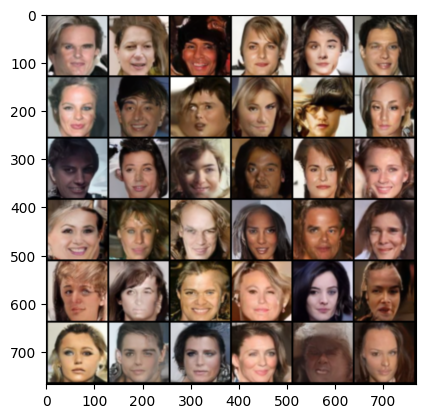

In [11]:
x = Image.open(images[0])

transform=transforms.Compose([
    transforms.Resize((128*6,128*6)),
    transforms.ToTensor()
])

# transform=transforms.Compose([
#     transforms.ToTensor()
# ])

x = transform(x)

plt.imshow(x.permute(1,2,0))

In [12]:
x.shape

torch.Size([3, 768, 768])

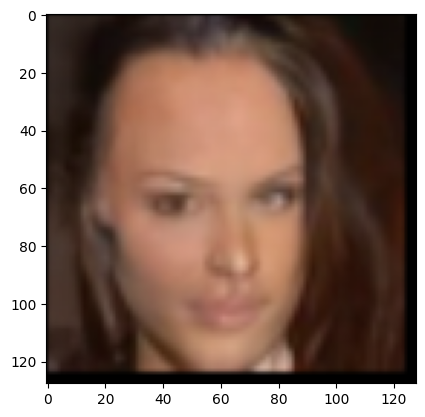

In [13]:
plt.imshow(x[:,128*5:128*6,128*5:128*6].permute(1,2,0))

In [14]:
model(x[:,128*5:128*6,128*5:128*6].unsqueeze(0).cuda())

/tmp/ipykernel_3789216/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor([[0.0629, 0.9371]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [15]:
train_x = []
train_y = []

In [16]:
from time import time

In [17]:
st = time()

for ix, img in enumerate(images):
    for i in range(6):
        for j in range(6):
            if ix % 100 == 0:
                print(ix, time() - st)
            # split images 6*6 one by one
            x_grid = transform(Image.open(img))
            x = x_grid[:, 128*i:128*(i+1), 128*j:128*(j+1)]
            pred_y = model(x.unsqueeze(0).cuda())
    
            np_x = x.cpu().numpy()
            np_y = torch.round(pred_y).cpu().detach().numpy()[0]
    
            train_x.append(np_x)
            train_y.append(np_y)

    # if ix>10000:
    #     break
    

0 0.0006451606750488281
0 0.03229331970214844
0 0.05045938491821289
0 0.06863594055175781
0 0.08334922790527344
0 0.09766864776611328
0 0.11210918426513672
0 0.12645673751831055
0 0.14096832275390625
0 0.15535974502563477
0 0.1696455478668213
0 0.18407464027404785
0 0.20097851753234863


/tmp/ipykernel_3789216/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


0 0.2168104648590088
0 0.23707365989685059
0 0.25170207023620605
0 0.26610875129699707
0 0.28060388565063477
0 0.29520559310913086
0 0.3095567226409912
0 0.324066162109375
0 0.33838415145874023
0 0.3528316020965576
0 0.3674123287200928
0 0.3817758560180664
0 0.39623498916625977
0 0.41311168670654297
0 0.4341723918914795
0 0.455674409866333
0 0.4779980182647705
0 0.49288392066955566
0 0.5074992179870605
0 0.5219686031341553
0 0.5365781784057617
0 0.5527477264404297
0 0.5740869045257568


In [18]:
import numpy as np

In [19]:
yy = [np.argmax(y) for y in train_y]

In [20]:
np.unique(yy, return_counts=True)

(array([0, 1]), array([1453,  707]))

In [25]:
joblib.dump(train_x, './train_celeba_x_exp_fake.pkl')
joblib.dump(train_y, './train_celeba_y_exp_fake.pkl')

['./train_celeba_y_exp_fake.pkl']

In [24]:
len(train_y[0])

2